# Model for decision on accepted/ rejected loan

In [1]:
# %load_ext lab_black


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functions as myFunc
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
)
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    classification_report,
)
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna
import shap
from joblib import dump

c:\Users\jonyt\anaconda3\envs\conda_ds_39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pd.set_option("float_format", "{:.2f}".format)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 150)
set_config(display="diagram")

# Accepted data

In [4]:
accepted_loan_df = pd.read_csv(
    "accepted_2007_to_2018Q4.csv", header=0, skiprows=lambda i: i % 10 != 0
)

Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.


## Data transformation

In [5]:
col_names = {
    "loan_amnt": "Amount Requested",
    "dti": "Debt-To-Income Ratio",
    "emp_length": "Employment Length",
    "Year_issue_d": "Year",
    "risk_score": "Risk_Score",
}
cleaned_df_accepted = (
    accepted_loan_df.pipe(myFunc.copy_df)
    .pipe(myFunc.drop_duplicates)
    .pipe(
        myFunc.date_split_to_Y_M,
        ["issue_d"],
    )
    .pipe(myFunc.replace_what_with_what, "term", " months", "")
    .pipe(myFunc.filter_column_range_0_to_100, "dti")
    .pipe(myFunc.employment_Length_to_numeric, "emp_length")
    .pipe(myFunc.log_feature, "loan_amnt")
    .pipe(myFunc.calc_risk, "fico_range_low", "fico_range_high")
    .pipe(
        myFunc.drop_columns,
        [
            "id",
            "member_id",
            "url",
            "purpose",
            "emp_title",
            "desc",
            "title",
            "zip_code",
            "policy_code",
            "next_pymnt_d",
            "earliest_cr_line",
            "sec_app_earliest_cr_line",
            "last_credit_pull_d",
            "issue_d",
            "last_pymnt_d",
            "next_pymnt_d",
            "settlement_date",
            "debt_settlement_flag_date",
            "hardship_end_date",
            "payment_plan_start_date",
            "hardship_start_date",
            "fico_range_low",
            "fico_range_high",
        ],
    )
    .pipe(
        myFunc.select_columns,
        [
            "loan_amnt",
            "risk_score",
            "dti",
            "emp_length",
            "Year_issue_d",
        ],
    )
    .pipe(myFunc.insert_status, 1)
    .pipe(myFunc.rename_columns, col_names)
)

In [6]:
cleaned_df_accepted.shape

(225648, 6)

In [7]:
cleaned_df_accepted.head()

,Amount Requested,Risk_Score,Debt-To-Income Ratio,Employment Length,Year,status
0,8000.00,702.00,34.80,10.00,2015.00,1
1,8650.00,677.00,25.49,8.00,2015.00,1
2,15000.00,687.00,15.34,10.00,2015.00,1
3,20000.00,692.00,12.45,6.00,2015.00,1
4,2500.00,672.00,17.60,10.00,2015.00,1


# Rejected data

In [8]:
rejected_loan_df = pd.read_csv(
    "rejected_2007_to_2018Q4.csv", header=0, skiprows=lambda i: i % 100 != 0
)


In [9]:
rejected_loan_df.shape

(276487, 9)

## Data transformation

In [10]:
cleaned_df_rejected = (
    rejected_loan_df.pipe(myFunc.copy_df)
    .pipe(myFunc.drop_duplicates)
    .pipe(myFunc.get_year_month, "Application Date")
    .pipe(myFunc.replace_what_with_what, "Debt-To-Income Ratio", "%", "")
    .pipe(myFunc.employment_Length_to_numeric, "Employment Length")
    .pipe(myFunc.filter_column_range_0_to_100, "Debt-To-Income Ratio")
    .pipe(myFunc.insert_status, 0)
    .pipe(
        myFunc.drop_columns,
        ["Application Date", "Zip Code", "State", "Loan Title", "Month", "Policy Code"],
    )
)

In [11]:
cleaned_df_rejected.head()

,Amount Requested,Risk_Score,Debt-To-Income Ratio,Employment Length,Year,status
0,1300.00,643.00,22.50,2.00,2007,0
1,17000.00,628.00,22.76,0.00,2007,0
2,13000.00,0.00,0.00,0.00,2007,0
3,8000.00,609.00,27.00,0.00,2007,0
4,2000.00,536.00,10.63,1.00,2007,0


Let's take a sample from both datasets. Before we dive into modeling, let's check if our sample can represent population well. 

In [12]:
cleaned_df_accepted_sample = cleaned_df_accepted.sample(n=50000, random_state=1)
rejected_sample = cleaned_df_rejected.sample(n=50000, random_state=1)
rejected_sample2 = cleaned_df_rejected.sample(n=50000, random_state=2)

In [13]:
rejected_sample.shape, rejected_sample2.shape, cleaned_df_accepted_sample.shape

((50000, 6), (50000, 6), (50000, 6))

We may see, that all 3 samples are same size, so the dataset will be balanced. Now let's check if samples have no bias.

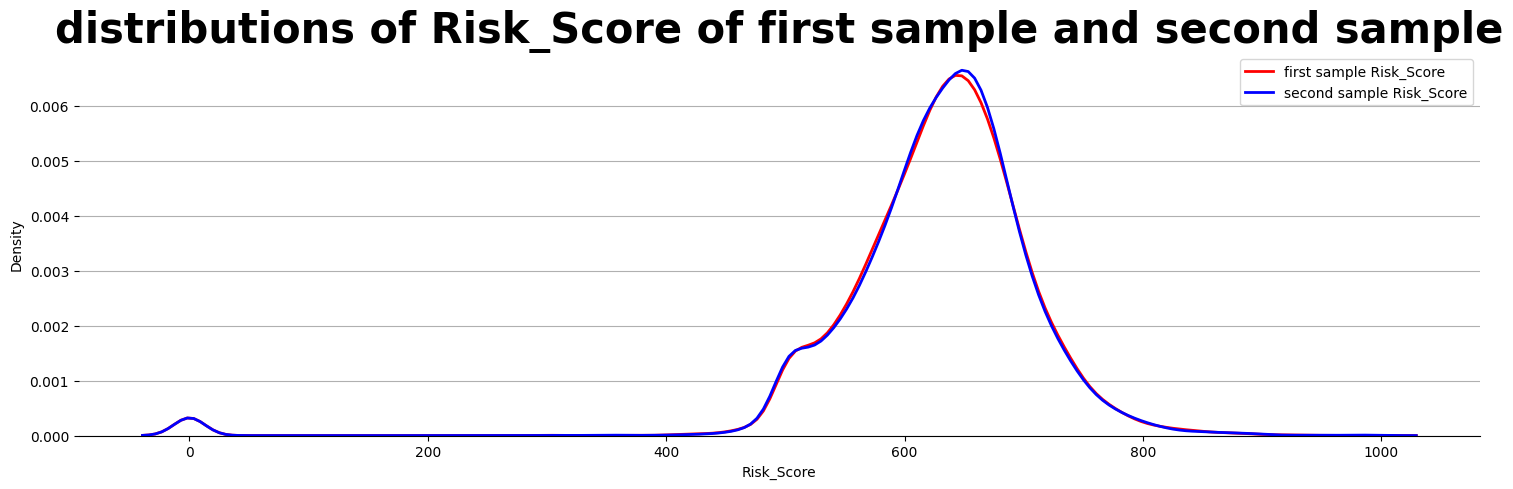

In [14]:
myFunc.compare_two_samples(rejected_sample, rejected_sample2, "Risk_Score")

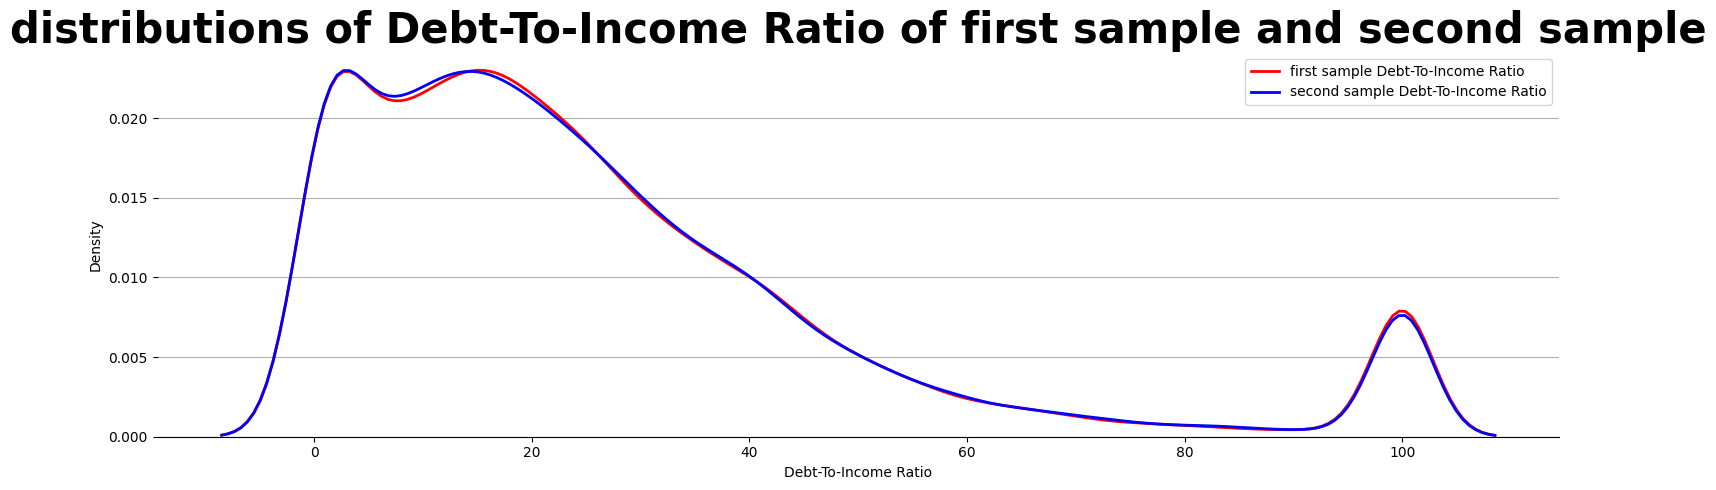

In [15]:
myFunc.compare_two_samples(rejected_sample, rejected_sample2, "Debt-To-Income Ratio")

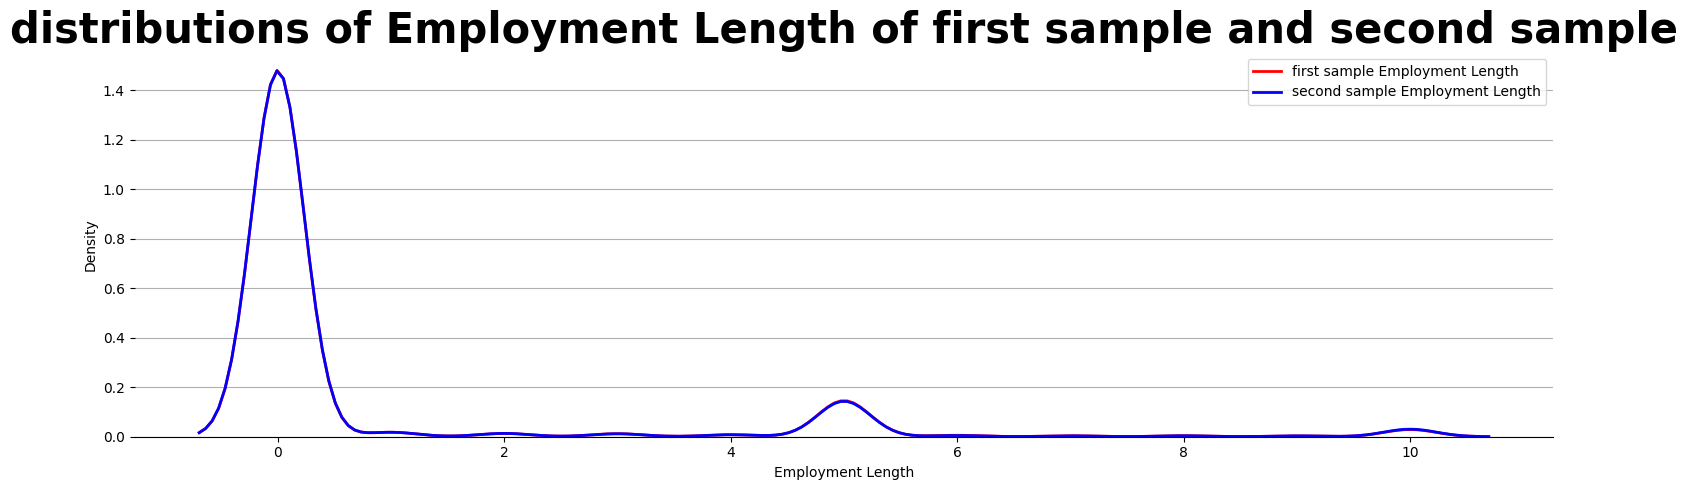

In [16]:
myFunc.compare_two_samples(rejected_sample, rejected_sample2, "Employment Length")

We may conclude that our selected 'rejected sample' for modeling accurately represents the population without bias. As a next step, we can proceed with deleting a few datasets to free up RAM memory

In [17]:
lst = [rejected_sample2, accepted_loan_df, cleaned_df_rejected]
del [rejected_sample2, accepted_loan_df, cleaned_df_rejected]
del lst

Let's concatinate rejected dataframe and accepted sample to get final table for the modeling.

In [18]:
df_for_model = pd.concat([rejected_sample, cleaned_df_accepted_sample])
df_for_model.shape

(100000, 6)

In [19]:
df_for_model.sample(5)

,Amount Requested,Risk_Score,Debt-To-Income Ratio,Employment Length,Year,status
59013,1400.00,722.00,11.13,3.00,2017.00,1
58352,40000.00,NaN,54.32,0.00,2018.00,0
224705,35000.00,NaN,41.60,0.00,2015.00,0
70674,4500.00,690.00,3.04,NaN,2013.00,0
126467,5000.00,NaN,100.00,0.00,2017.00,0


Now we have final table for modeling. Before moving futher let's replace column names.

In [20]:
df_for_model = df_for_model.rename(
    columns={
        "Amount Requested": "amount_requested",
        "Risk_Score": "risk_score",
        "Employment Length": "employment_length",
        "Debt-To-Income Ratio": "debt_to_income_ratio",
        "Year": "year",
    }
)

# Modeling

In order to avoid "see the future" efect, we should use 2018 data for testing and validation. 

In [21]:
df_val_and_test = df_for_model.loc[df_for_model["year"] == 2018.00]

In [22]:
df_test, df_valid = train_test_split(
    df_val_and_test,
    test_size=0.5,
    random_state=1,
    stratify=df_val_and_test["status"],
)

Training data will be 2007-2017:

In [23]:
df_train = df_for_model.loc[df_for_model["year"] != 2018.00]

In [24]:
X_train = df_train.drop("status", axis=1)
y_train = df_train["status"]
X_val = df_valid.drop("status", axis=1)
y_val = df_valid["status"]
X_test = df_test.drop("status", axis=1)
y_test = df_test["status"]

In [25]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((71570, 5), (71570,), (14215, 5), (14215,), (14215, 5), (14215,))

In [26]:
y_train.value_counts(), y_val.value_counts(), y_test.value_counts()

(status
 1    39167
 0    32403
 Name: count, dtype: int64,
 status
 0    8798
 1    5417
 Name: count, dtype: int64,
 status
 0    8799
 1    5416
 Name: count, dtype: int64)

We may see, that all splits are imbalanced.

**Splitting columns into 2 categories**

In [27]:
one_hot_features = ["employment_length"]

numerical_features = ["amount_requested", "risk_score", "debt_to_income_ratio", "year"]

In [28]:
feature_engineering_pipe = Pipeline(
    [
        (
            "new_features",
            ColumnTransformer(
                [
                    (
                        "risk_times_dti",
                        FunctionTransformer(myFunc.get_risk_times_dti, validate=False),
                        ["risk_score", "debt_to_income_ratio"],
                    ),
                ]
            ),
        ),
        (
            "imputer",
            SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=-9999),
        ),
    ]
)

Let's test our pipe, if it is working as expected.

In [29]:
test = feature_engineering_pipe.fit_transform(X_train)
test_df = pd.DataFrame(
    test,
    columns=["risk_times_dti"],
)
test_df.sample(5)

,risk_times_dti
57208,15235.85
24064,-9999.00
47504,10995.84
37957,10106.88
18569,-9999.00


Our feature engineering pipe looks doing right things. Next, let's create pipe for numeric features.

In [30]:
numeric_transformer = Pipeline(
    steps=[
        (
            "imputer",
            SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=-9999),
        ),
    ]
)

In [31]:
one_hot_transformer = Pipeline(
    steps=[
        (
            "imputer",
            SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=-9999),
        ),
        ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
    ]
)

Now let's create prepocessor from all transformers and pipes we have created so far.

In [32]:
preprocessor = ColumnTransformer(
    transformers=[
        ("features", feature_engineering_pipe, numerical_features),
        ("numeric_tr", numeric_transformer, numerical_features),
        ("one_hot_tr", one_hot_transformer, one_hot_features),
    ]
)


# Base model selection

In [33]:
def base_models(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    preprocessor: np.array,
) -> pd.DataFrame:
    """
    Takes x and y dataframes.
    Perform cross validation with different models.
    Returns table with metrics and results
    """
    roc_auc = []
    accuracy = []
    recall = []
    precision = []
    f1_score = []
    fit_time = []

    counter = Counter(y_train)
    estimate = counter[0] / counter[1]

    classifiers = [
        "XGB classifier",
        "Random Forest",
        "LGBM classifier",
        "AdaBoost Classifier",
    ]
    models = [
        XGBClassifier(scale_pos_weight=estimate),
        RandomForestClassifier(class_weight="balanced", n_estimators=100),
        LGBMClassifier(scale_pos_weight=estimate, force_col_wise=True),
        AdaBoostClassifier(),
    ]

    for model in models:
        pipeline = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("classifier", model),
            ]
        )

        cv = StratifiedKFold(random_state=123, shuffle=True)

        result = cross_validate(
            pipeline,
            X_train,
            y_train,
            cv=cv,
            scoring=(
                "accuracy",
                "f1_macro",
                "recall_macro",
                "precision_macro",
                "roc_auc",
            ),
        )

        fit_time.append(result["fit_time"].mean())
        accuracy.append(result["test_accuracy"].mean())
        recall.append(result["test_recall_macro"].mean())
        precision.append(result["test_precision_macro"].mean())
        f1_score.append(result["test_f1_macro"].mean())
        roc_auc.append(result["test_roc_auc"].mean())

    base_models = pd.DataFrame(
        {
            "Accuracy": accuracy,
            "Recall": recall,
            "Precision": precision,
            "f1": f1_score,
            "Roc Auc": roc_auc,
            "Fit_time": fit_time,
        },
        index=classifiers,
    )

    return base_models

In [34]:
base_data = base_models(X_train, y_train, preprocessor)

[LightGBM] [Info] Number of positive: 31334, number of negative: 25922
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 57256, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547261 -> initscore=0.189612
[LightGBM] [Info] Start training from score 0.189612
[LightGBM] [Info] Number of positive: 31334, number of negative: 25922
[LightGBM] [Info] Total Bins 1055
[LightGBM] [Info] Number of data points in the train set: 57256, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547261 -> initscore=0.189612
[LightGBM] [Info] Start training from score 0.189612
[LightGBM] [Info] Number of positive: 31334, number of negative: 25922
[LightGBM] [Info] Total Bins 1054
[LightGBM] [Info] Number of data points in the train set: 57256, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547261 -> initscore=0.189612
[LightGBM] [Info] Start training from score 0.189612
[LightGBM]

In [35]:
base_data.sort_values(by="f1", ascending=False)

,Accuracy,Recall,Precision,f1,Roc Auc,Fit_time
LGBM classifier,0.98,0.98,0.99,0.98,1.00,0.43
XGB classifier,0.97,0.97,0.98,0.97,0.99,0.46
Random Forest,0.96,0.96,0.96,0.96,0.99,11.05
AdaBoost Classifier,0.96,0.96,0.96,0.96,0.99,3.03


All models are showing good results, so I will choose LGBM classifier and XGB classifier because, thease models takes less time to train.

## Tuning of LGBM classifier

In [36]:
def objective_lgbm(trial):
    """Suggests values for hyperparameters, fits model and makes predictions and calculates f1 score"""

    params = {
        "num_boost_round": trial.suggest_int("num_boost_round", 0, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "verbose": -1,
    }

    counter = Counter(y_train)
    estimate = counter[0] / counter[1]

    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "classifier",
                LGBMClassifier(
                    **params, scale_pos_weight=estimate, force_col_wise=True
                ),
            ),
        ]
    )
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_val)

    roc = roc_auc_score(y_val, y_pred)
    return roc

In [37]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_lgbm, n_trials=30)


[I 2023-10-27 00:04:57,876] A new study created in memory with name: no-name-60e9cbbb-5c1f-4e1a-9628-7fad7c81eb69
Found `num_boost_round` in params. Will use it instead of argument
[I 2023-10-27 00:04:58,534] Trial 0 finished with value: 0.9686165395050303 and parameters: {'num_boost_round': 279, 'learning_rate': 0.18468677197207875, 'num_leaves': 1940, 'max_depth': 4, 'min_data_in_leaf': 3000, 'lambda_l1': 80, 'lambda_l2': 70, 'min_gain_to_split': 9.7303957944152}. Best is trial 0 with value: 0.9686165395050303.
Found `num_boost_round` in params. Will use it instead of argument
[I 2023-10-27 00:04:59,684] Trial 1 finished with value: 0.9696318616390528 and parameters: {'num_boost_round': 594, 'learning_rate': 0.1601880802970321, 'num_leaves': 1520, 'max_depth': 6, 'min_data_in_leaf': 3700, 'lambda_l1': 85, 'lambda_l2': 45, 'min_gain_to_split': 7.043931210043181}. Best is trial 1 with value: 0.9696318616390528.
Found `num_boost_round` in params. Will use it instead of argument
[I 2023-

In [38]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")

for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


Number of finished trials: 30
Best trial:
  Value: 0.9904070638337552
  Params: 
    num_boost_round: 937
    learning_rate: 0.21232479538737248
    num_leaves: 1460
    max_depth: 7
    min_data_in_leaf: 4200
    lambda_l1: 20
    lambda_l2: 45
    min_gain_to_split: 0.005856139172845332


## Refitting LGBM classifier with the best parameters

In [39]:
params_best = trial.params

counter = Counter(y_train)
estimate = counter[0] / counter[1]

pipeline1 = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            LGBMClassifier(
                **params_best,
                scale_pos_weight=estimate,
                force_col_wise=True,
                verbose=-1
            ),
        ),
    ]
)
model = pipeline1.fit(X_train, y_train)
y_pred = model.predict(X_val)

Found `num_boost_round` in params. Will use it instead of argument



Classification Report for LightGBM
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8798
           1       1.00      0.98      0.99      5417

    accuracy                           0.99     14215
   macro avg       0.99      0.99      0.99     14215
weighted avg       0.99      0.99      0.99     14215



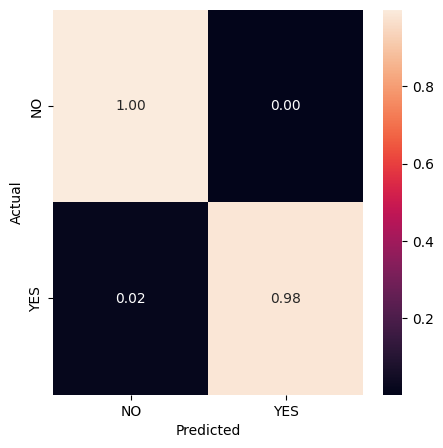

In [40]:
print("\nClassification Report for LightGBM")
print(classification_report(y_val, y_pred))
myFunc.confusion_matrix_normalized(y_val, y_pred, ["NO", "YES"])

Tuned LightGBM results are very good, we managed to get 98% accuracy, 0,98 f1 score for positive group.  
Now let's try XGB hyper parameter tunig.

## Tuning of XGB classifier

In [45]:
def objective_xgb(trial):
    """Suggests values for hyperparameters, fits model and makes predictions and calculates f1 score"""

    params = {
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
        "subsample": trial.suggest_loguniform("subsample", 0.01, 1.0),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.01, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 1.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 1.0),
        "eval_metric": "mlogloss",
        "use_label_encoder": False,
    }
    counter = Counter(y_train)
    estimate = counter[0] / counter[1]

    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", XGBClassifier(**params, scale_pos_weight=estimate)),
        ]
    )
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_val)

    roc = roc_auc_score(y_val, y_pred)
    return roc

In [46]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_xgb, n_trials=50)

[I 2023-10-27 00:10:16,168] A new study created in memory with name: no-name-9fe7cf18-19cc-48d1-a226-33bbb8d9f1fd
[I 2023-10-27 00:10:17,434] Trial 0 finished with value: 0.9745238682847978 and parameters: {'max_depth': 9, 'learning_rate': 0.08501658736085144, 'n_estimators': 147, 'min_child_weight': 8, 'gamma': 1.262045851316945e-06, 'subsample': 0.017640662071775136, 'colsample_bytree': 0.630154281834768, 'reg_alpha': 0.00018246779705549294, 'reg_lambda': 0.0068385013587797345}. Best is trial 0 with value: 0.9745238682847978.
[I 2023-10-27 00:10:18,118] Trial 1 finished with value: 0.9304782041566079 and parameters: {'max_depth': 5, 'learning_rate': 0.06735976931558026, 'n_estimators': 113, 'min_child_weight': 10, 'gamma': 0.42908928906110866, 'subsample': 0.32038388991987127, 'colsample_bytree': 0.017459274764349036, 'reg_alpha': 3.4379061986095704e-05, 'reg_lambda': 4.7105810905698706e-07}. Best is trial 0 with value: 0.9745238682847978.
[I 2023-10-27 00:10:18,740] Trial 2 finished

In [47]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")

for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 50
Best trial:
  Value: 0.984194219380334
  Params: 
    max_depth: 8
    learning_rate: 0.06498309915859793
    n_estimators: 431
    min_child_weight: 2
    gamma: 8.180762286323901e-06
    subsample: 0.3317244354169742
    colsample_bytree: 0.2197847904464896
    reg_alpha: 1.0053534745366073e-08
    reg_lambda: 0.00015509561845373953


# Refitting XGB classifier with the best parameters

In [51]:
params_best = trial.params

counter = Counter(y_train)
estimate = counter[0] / counter[1]

pipeline_XGB = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(**params_best, scale_pos_weight=estimate)),
    ]
)
model = pipeline_XGB.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8798
           1       0.99      0.97      0.98      5417

    accuracy                           0.99     14215
   macro avg       0.99      0.98      0.99     14215
weighted avg       0.99      0.99      0.99     14215



So I will save XGBclassifier as my final model, because it showed slighly better results then LGBMClassifier with f1 for possitive class 0,99 and accuracy of 99%. Now, let's make predictions using our test set.

# Final model on test set

In [52]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8799
           1       0.99      0.97      0.98      5416

    accuracy                           0.99     14215
   macro avg       0.99      0.98      0.99     14215
weighted avg       0.99      0.99      0.99     14215



We may see, that our model is predicting almost perfectly, all metrics are almost 100%. Given the imbalanced nature of our data, it would be more appropriate to use the PR-AUC (Precision-Recall Area Under the Curve) metric. PR-AUC effectively assesses the trade-off between presision and recall for class 1.

Text(0.5, 1.0, 'Test Precision-Recall curve')

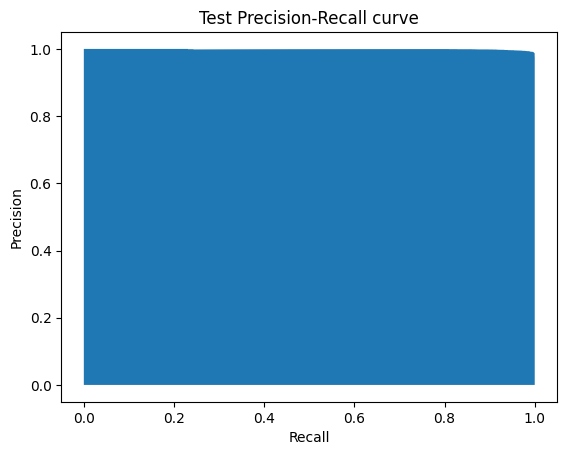

In [50]:
y_prob_test = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_test)
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Test Precision-Recall curve")

Our analysis of this the PR-AUC (Precision-Recall Area Under the Curve) metric suggests that the model's performance for class 1 is exceptionally strong, approaching near-perfection.

### Model explanation with SHAP

Now let's explore wich features made the bigest impact on accepting/ rejecting loan predictions.

**KernelExplainer**

In [214]:
X_test_tr = pipeline_XGB[:-1].transform(X_test)
explainer = shap.TreeExplainer(pipeline_XGB[-1])
shap_values = explainer.shap_values(X_test_tr)

[16:11:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [215]:
explainer = shap.TreeExplainer(pipeline_XGB["classifier"])
shap_values = explainer(preprocessor.transform(X_val))

In [216]:
one_hot = list(
    pipeline_XGB.named_steps["preprocessor"]
    .transformers_[2][1]
    .named_steps["onehot"]
    .get_feature_names_out(one_hot_features)
)

cat_all = ["risk_times_dti"] + numerical_features + one_hot
cat_all

['risk_times_dti',
 'amount_requested',
 'risk_score',
 'debt_to_income_ratio',
 'year',
 'employment_length_-9999.0',
 'employment_length_0.0',
 'employment_length_1.0',
 'employment_length_2.0',
 'employment_length_3.0',
 'employment_length_4.0',
 'employment_length_5.0',
 'employment_length_6.0',
 'employment_length_7.0',
 'employment_length_8.0',
 'employment_length_9.0',
 'employment_length_10.0']

In [217]:
shap.initjs()

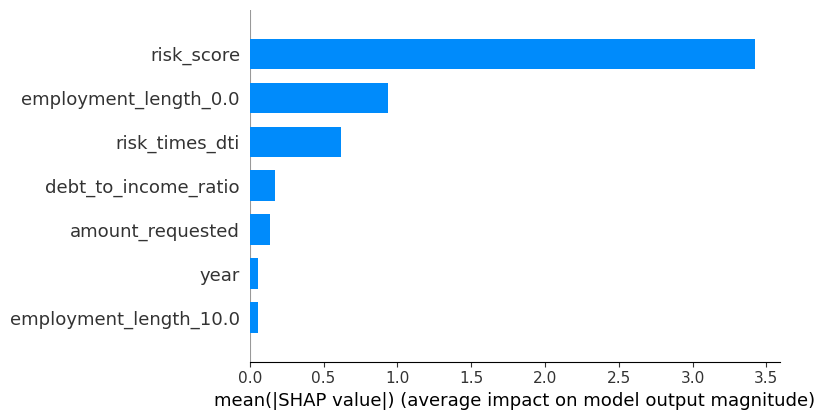

In [218]:
shap.summary_plot(shap_values, feature_names=cat_all, plot_type="bar", max_display=7)

Text(0.5, 1.0, 'Feature importance')

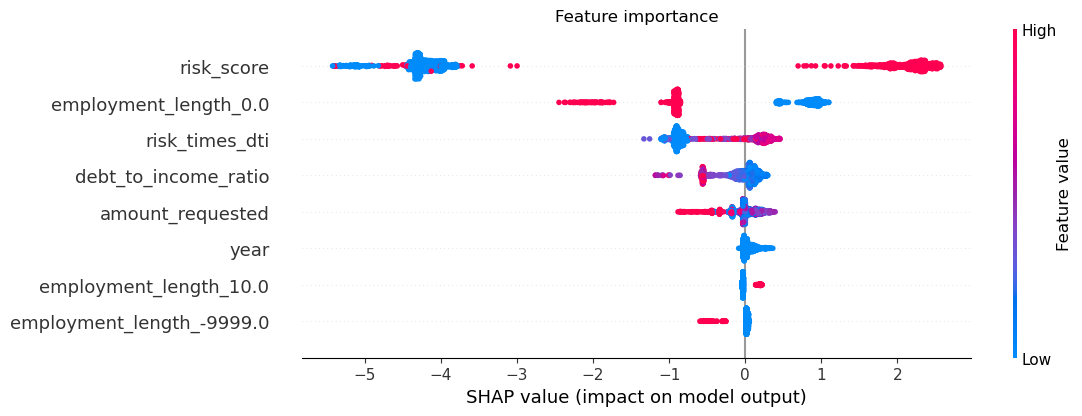

In [219]:
shap.summary_plot(
    shap_values,
    preprocessor.transform(X_val),
    feature_names=cat_all,
    max_display=8,
    show=False,
)

fig, ax = plt.gcf(), plt.gca()

fig.set_size_inches(14, 4)
ax.set_title("Feature importance", fontdict={"size": 12})

In [220]:
dump(pipeline_XGB, "loan_classifier.joblib")


['loan_classifier.joblib']

We may see, that Risk score and Employment Length less then one year had the biggest predicting power, so thaese features are most important.

We successfully improved the F1 score from 0.96 to 0.98 by fine-tuning the hyperparameters for the XGBoost Classifier. This represents the best possible model achievable using this approach.